Using TensorFlow backend.
C:\Users\hp\Anaconda3\lib\site-packages\numpy\core\_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)


Episode:0, iterations:23, RAP:0.99
Episode:1, iterations:14, RAP:0.9801
Episode:2, iterations:14, RAP:0.9702989999999999
Episode:3, iterations:19, RAP:0.96059601
Episode:4, iterations:8, RAP:0.9509900498999999
Episode:5, iterations:17, RAP:0.9414801494009999
Episode:6, iterations:10, RAP:0.9320653479069899
Episode:7, iterations:37, RAP:0.92274469442792
Episode:8, iterations:19, RAP:0.9135172474836407
Episode:9, iterations:11, RAP:0.9043820750088043
Episode:10, iterations:13, RAP:0.8953382542587163
Episode:11, iterations:17, RAP:0.8863848717161291
Episode:12, iterations:24, RAP:0.8775210229989678
Episode:13, iterations:13, RAP:0.8687458127689781
Episode:14, iterations:57, RAP:0.8600583546412883
Episode:15, iterations:36, RAP:0.8514577710948754
Episode:16, iterations:14, RAP:0.8429431933839266
Episode:17, iterations:26, RAP:0.8345137614500874
Episode:18, iterations:10, RAP:0.8261686238355865
Episode:19, iterations:12, RAP:0.8179069375972307
Episode:20, iterations:28, RAP:0.80972786822125

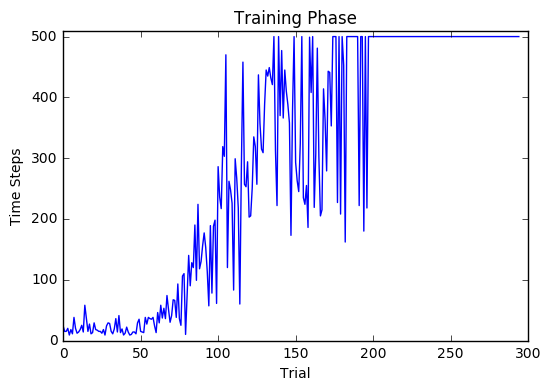

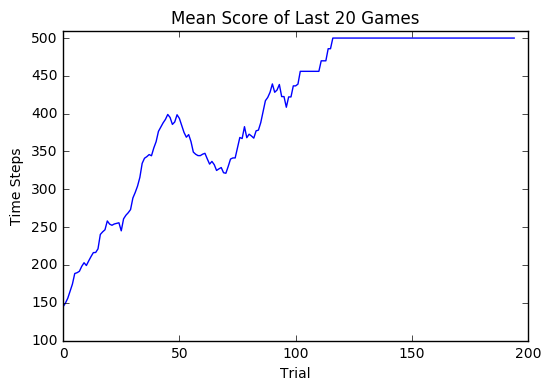

500.0


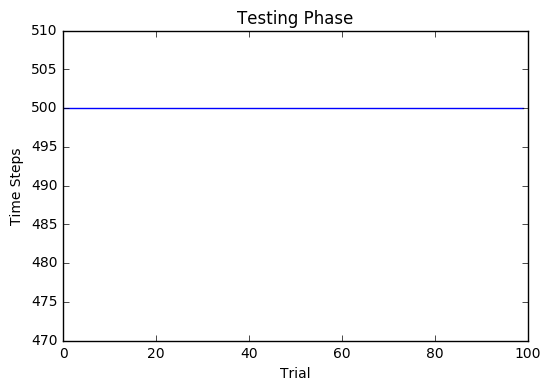

In [1]:
########
## @author Vaibhav Bhilare
## @copyright 2017, Vaibhav Bhilare
## ENPM 808F: Final Project
## Balancing a pole on a cart using Deep Reinforcement Learning
########

import gym  ## Import the OpenAI gym
import keras  ## Import the Keras
import numpy as np  ## Import Numpy
import random  ## Import random for probability generation
import matplotlib.pyplot as plt  ## For plotting
from random import shuffle  ## For shuffling the Replay Memory

from gym import wrappers  ## gym wrappers for monitoring
from keras.models import Sequential  ## Sequential model from Keras
from keras.layers import Dense  ## Dense Layer from Keras
from keras.optimizers import Adam  ## Adam Optimizer from Keras
from keras.models import load_model  ## For saving and loading the Keras model

from collections import deque  ## Deque for storing samples in Replay Memory 

ACTIONS_DIM = 2  ## Output Dimension=No. of possible actions (2)
OBSERVATIONS_DIM = 4  ## Input Dimension= No of Elements in State Tuple (4)
MAX_ITERATIONS = 500  ## Max Time Steps Per Game (Limited to 500 by Environment)
LEARNING_RATE = 0.001
NUM_EPOCHS = 50

GAMMA = 0.99  ## Future Reward Discount Factor
REPLAY_MEMORY_SIZE = 10000  ## Replay Memory Size
NUM_EPISODES = 600  ## Games Played in Training Phase
MINIBATCH_SIZE = 64  ## Number of Samples chosen randomly from Replay Memory

RANDOM_ACTION_DECAY = 0.99  ## The factor by which Random Action Probability Decreases
INITIAL_RANDOM_ACTION = 1  ## Initial Random Action Factor
Samples=[]  ## A list to store Individual Game Scores
Means=[]  ## A list to store Mean Score over Last 20 Games


####
##  @class ReplayBuffer()
##  This class is used to initialize, store and update the Replay Memory
####
class ReplayBuffer():
    def __init__(self, max_size):  ## Initialize the Replay Memory
        self.max_size = max_size  ## Set Maximum size to REPLAY_MEMORY_SIZE
        self.transitions = deque()  ## Initialize a deque to store all samples

    def add(self, observation, action, reward, observation2):  ## Function to add sample to the memory
        if len(self.transitions) > self.max_size:  ## If size exceeds the max limit, remove an item
            if np.random.random()<0.5:
                shuffle(self.transitions)  ## Shuffle the Replay Memory
            self.transitions.popleft()  ## Remove a Sample
        self.transitions.append((observation, action, reward, observation2))  ## Add a Sample to memory

    def sample(self, count):  ## Function to randomly select samples=Minibatch size(count)
        return random.sample(self.transitions, count)  ## Select from transitions(Memory)

    def size(self):  ## Function to keep track of Replay Memory Size 
        return len(self.transitions)  ## Returns the length of the Replay Memory

def get_q(model, observation):  ## Function to Predict Q-Values from the Model
    np_obs = np.reshape(observation, [-1, OBSERVATIONS_DIM])  ## Reshape the state
    return model.predict(np_obs)  ## Query the Model for possible actions and corresponding Q-Values

def train(model, observations, targets):  ## Function to Train the Model
    np_obs = np.reshape(observations, [-1, OBSERVATIONS_DIM])  ## Reshape the State
    np_targets = np.reshape(targets, [-1, ACTIONS_DIM])  ## Reshape the Target

    model.fit(np_obs, np_targets, epochs=1, verbose=0)  ## Fit the model using State-Target Pairs

def predict(model, observation):  ## Function to Predict Q-Values from Model
    np_obs = np.reshape(observation, [-1, OBSERVATIONS_DIM])  ## Reshape the State
    return model.predict(np_obs)  ## Query the Model for possible actions and corresponding Q-Values

def get_model():  ## Build the Deep Q-Network
    model = Sequential()  ## Type of Model
    ####
    ## Input layer of Dimension 4 and a Hidden Layer of 24 nodes. Activation 'relu'
    ####
    model.add(Dense(24, input_shape=(OBSERVATIONS_DIM, ), activation='relu'))
    model.add(Dense(24, activation='relu'))  ## Add second Hidden Layer of 24 nodes. Activation 'relu'
    model.add(Dense(2, activation='linear'))  ## Add output layer of dimension 2. Activation 'linear'

    model.compile(  ## Compile the Model
        optimizer=Adam(lr=LEARNING_RATE),  ## Adam Optimizer with Initial Learning Rate=0.001 
        loss='mse',  ## MSE Loss
        metrics=[],
    )

    return model

def update_action(action_model, target_model, sample_transitions):  ## Update the model
    random.shuffle(sample_transitions)  ## Randomly Shuffle the Minibatch Samples
    batch_observations = []  ## Initialize State(Observation) List
    batch_targets = []  ## Initialize Target(Output Label) List

    for sample_transition in sample_transitions:  ## For each sample in Minibatch
        old_observation, action, reward, observation = sample_transition  ## Separate each part of observation
        
        ####
        ## Reshape targets to output dimension(=2)
        ####
        targets = np.reshape(get_q(action_model, old_observation), ACTIONS_DIM)
        targets[action] = reward  ## Set Target Value
        if observation is not None:  ## If observation is not Empty
            
            ####
            ## Query the Model for possible actions and corresponding Q-Values
            ####
            predictions = predict(target_model, observation) 
            new_action = np.argmax(predictions)  ## Select the Best Action (Max Q-Value)
            targets[action] += GAMMA * predictions[0, new_action]  ## Update the Target with Future Reward Discount Factor

        batch_observations.append(old_observation)  ## Add Old State to observations batch
        batch_targets.append(targets)  ## Add target to targets batch

    ## Update the model using Observations and their corresponding Targets
    train(action_model, batch_observations, batch_targets)

def main():
    Temp=[]  ## Initialize a list to hold most recent 100 Game Scores
    iteration=0  ## Initialize Time Step Number to Avoid initial No variable Error
    random_action_probability = INITIAL_RANDOM_ACTION  ## Set Random Action Probability to Initial Number(=1)

    replay = ReplayBuffer(REPLAY_MEMORY_SIZE)  ## Initialize Replay Memory & Specify Maximum Capacity

    action_model = get_model()  ## Initialize action-value model with random weights

    env = gym.make('CartPole-v1')  ## Prepare the OpenAI Cartpole-v1 Environment

    for episode in range(NUM_EPISODES):  ## For Games 0 to Maximum Games Limit
        if np.mean(Temp)>495 and iteration>495:  ## If mean over the last 100 Games is >495, then Success!!!
            print('Passed')  ## Print the information that the model is converged
            break  ## Terminate after convergence
        random_action_probability *= RANDOM_ACTION_DECAY  ## Reduce the Random Action Probability by Decay Factor
        observation = env.reset()  ## Reset the Environment after Each Game

        for iteration in range(MAX_ITERATIONS):  ## Timesteps
            random_action_probability = max(random_action_probability, 0.1)  ## Generate Random Action Probability
            old_observation = observation  ## Store Current State
            if np.random.random() < random_action_probability:  ## If generated fraction<Random Action Probability
                action = np.random.choice(range(ACTIONS_DIM))  ## Take Random Action (Explore)
            else:  ## If generated fraction>Random Action Probability
                q_values = get_q(action_model, observation)  ## Query the Model and Get Q-Values for possible actions
                action = np.argmax(q_values)  ## Select the Best Action using Q-Values received

            observation, reward, done, info = env.step(action)  ## Take the Selected Action and Observe Next State

            if done:  ## If Game Over
                Samples.append(iteration+1)  ## Add Final Score of the Game to the Scores List
                if len(Samples)>100:  ## If Number of Games>100, Calculate Mean Over 100 Games to Check Convergence
                    Temp=Samples[-100:]  ## Select Score of Most Recent 100 Games
                    Means.append(np.mean(Samples[-20:]))  ## Add Mean of Most Recent 20 Games to a list
                print(('Episode:{}, iterations:{}, RAP:{}').format(  ## Print End-Of-Game Information
                  episode,
                  iteration,random_action_probability
                ))

                if iteration!=499:
                    reward = -5  ## Give -5 Reward for Taking Wrong Action Leading to Failure
                if iteration==499:
                    reward= 5  ## Give +5 Reward for Completing the Game Successfully
                replay.add(old_observation, action, reward, None)  ## Add the Observation to Replay Memory
                break  ## Break and Start a new Game

            replay.add(old_observation, action, reward, observation)  ## Add the Observation to Replay Memory

            ####
            ##  Update the Deep Q-Network Model
            ####
            if replay.size() >= MINIBATCH_SIZE and np.random.random()<0.25 and Samples[-1]<495:
                sample_transitions = replay.sample(MINIBATCH_SIZE)
                update_action(action_model, action_model, sample_transitions)


####
##  Here, the Training Phase Ends. Now We plot the Training Results and Save the Trained Model
##  We Also Test the Model for Another 100 Games.
####

    print("Training Done")
    plt.plot(Samples)
    plt.title('Training Phase')
    plt.ylabel('Time Steps')
    plt.ylim(ymax=510)
    plt.xlabel('Trial')
    plt.savefig('Training.png', bbox_inches='tight')
    plt.show()
    
    plt.plot(Means)
    plt.title('Mean Score of Last 20 Games')
    plt.ylabel('Time Steps')
    plt.ylim(ymax=510)
    plt.xlabel('Trial')
    plt.savefig('Training_Average.png', bbox_inches='tight')
    plt.show()
    action_model.save('cartpole_model.h5')  ## Save the Trained Model
    del action_model
    action_model = load_model('cartpole_model.h5')  ## Load the Trained Model

## Here We test the trained model for 100 more games
    Tests=[]  ## Initialize the Game Score List
    for i in range(0,100):  ## Testing for 100 Games
        observation = env.reset()
        while(True):
            old_observation = observation
            q_values = get_q(action_model, observation)
            action = np.argmax(q_values)
            observation, reward, done, info = env.step(action)
            if done:
                Tests.append(iteration+1)
                env.reset()
                break
    print(np.mean(Tests))
    plt.plot(Tests)
    plt.title('Testing Phase')
    plt.ylabel('Time Steps')
    plt.ylim(ymax=510)
    plt.xlabel('Trial')
    plt.savefig('Testing.png', bbox_inches='tight')
    plt.show()
            
            
        

if __name__ == "__main__":
    main()

500.0


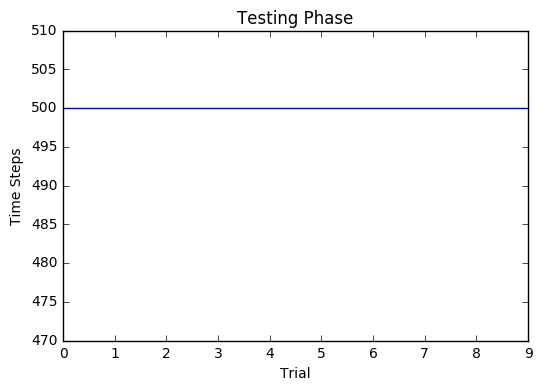

In [2]:
action_model = load_model('cartpole_model.h5')
env = gym.make('CartPole-v1')
Tests=[]
for i in range(0,10):
        observation = env.reset()
        for iteration in range(MAX_ITERATIONS):
            old_observation = observation
            q_values = get_q(action_model, observation)
            action = np.argmax(q_values)
            observation, reward, done, info = env.step(action)
            env.render()
            if done:
                Tests.append(iteration+1)
                env.reset()
                break
print(np.mean(Tests))
plt.plot(Tests)
plt.title('Testing Phase')
plt.ylabel('Time Steps')
plt.ylim(ymax=510)
plt.xlabel('Trial')
# plt.savefig('Testing_Again.png', bbox_inches='tight')
plt.show()